<a href="https://colab.research.google.com/github/hadine30/Human-activity-detection/blob/main/DTW_et_ACP_de_Projet_MCS_Etudiant.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [119]:
!unzip -d "/content/projet" "/content/drive/MyDrive/ProjetMCS_Etudiant.zip" 

Archive:  /content/drive/MyDrive/ProjetMCS_Etudiant.zip
replace /content/projet/ProjetMCS_Etudiant.1/WISDM_ar_v1.1_raw_about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: /content/projet/ProjetMCS_Etudiant.1/WISDM_ar_v1.1_raw_about.txt  
  inflating: /content/projet/__MACOSX/ProjetMCS_Etudiant.1/._WISDM_ar_v1.1_raw_about.txt  
  inflating: /content/projet/ProjetMCS_Etudiant.1/.DS_Store  
  inflating: /content/projet/__MACOSX/ProjetMCS_Etudiant.1/._.DS_Store  
  inflating: /content/projet/ProjetMCS_Etudiant.1/HARDataset.JPG  
  inflating: /content/projet/__MACOSX/ProjetMCS_Etudiant.1/._HARDataset.JPG  
  inflating: /content/projet/ProjetMCS_Etudiant.1/AlgoKppv.png  
  inflating: /content/projet/__MACOSX/ProjetMCS_Etudiant.1/._AlgoKppv.png  
  inflating: /content/projet/ProjetMCS_Etudiant.1/kppv.png  
  inflating: /content/projet/ProjetMCS_Etudiant.1/WISDM_ar_v1.1_raw.txt  
  inflating: /content/projet/__MACOSX/ProjetMCS_Etudiant.1/._WISDM_ar_v1.1_raw.txt  
  inflating: /cont

In [120]:
%cd /content/projet/ProjetMCS_Etudiant.1

/content/projet/ProjetMCS_Etudiant.1


# Projet MCS :  Détection d'activité humaine - DTW et classification avec réduction de dimension




Dans ce projet, nous essaierons de prédire l'activité humaine (1-Descendre, 2-Courir, 3-Assis, 4-Debout, 5-Monter ou 6-Marcher) en utilisant les capteurs du smartphone. C'est-à-dire qu'en utilisant les méthodes suivantes, le smartphone peut détecter ce que nous faisons en ce moment.


En utilisant l'accéléromètre  intégré dans le smartphone,  l'accélération linéaire 3-axes à un taux constant de 50Hz ont été relevées. Les expériences ont été enregistrées sur vidéo pour étiqueter les données manuellement. 

<img src="/content/projet/ProjetMCS_Etudiant.1/HARDataset.JPG" width="800" height="600"  >

Il est fourni pour chaque enregistrement de l'ensemble de données : 
- L'accélération triaxiale de l'accéléromètre (accélération totale) et l'accélération estimée du corps. 
- Son étiquette d'activité. 
- Un identifiant du sujet qui a réalisé l'expérience.


Ces 5 séances se décomposent en 4 parties : 
- Partie I : DTW et application du TD
- Partie II : Système de reconnaissance d'activité physique avec la DTW
- Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données par ACP
- Partie IV : Votre étude

**Travail à rendre**

Pour cela, vous devez par binômes (effectif **OBLIGATOIRE**):
1. Implémenter la DTW, tester les exercices de TD;
3. Utilser la DTW pour créer un système de reconnaissance;
4. Evaluer les résultats en utilisant la matrice de confusion et le pourcentage de bonne classification;
5. Implémenter l'ACP et les kppv 
6. Rédiger un rapport en pdf présentant votre étude : les résultats par les 2 méthodes et vos commentaires et conclusions sur une étude plus générale en modifiant les tailles des ensembles de test et d'apprentissage, en changeant le nombre de classes  (Longeur max. : 10 pages).


**Dataset et description :**
https://archive.ics.uci.edu/ml/datasets/WISDM+Smartphone+and+Smartwatch+Activity+and+Biometrics+Dataset+





In [121]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import math
from scipy import stats
import seaborn as sns

In [122]:
# Paramètres du dataset
COLUMN_NAMES = [
    'user',
    'activity',
    'timestamp',
    'x-axis',
    'y-axis',
    'z-axis'
]

LABELS = [
    'Downstairs',
    'Jogging',
    'Sitting',
    'Standing',
    'Upstairs',
    'Walking'
]

DATA_PATH = './WISDM_ar_v1.1_raw.txt'


# Durée des profils temporels
TIME_STEP = 60

# Paramètres
N_CLASSES = 3
N_FEATURES = 3  # x-acceleration, y-acceleration, z-acceleration
SEGMENT_TIME_SIZE = 30
TAILLE_TEST=50
TAILLE_APP=10

## 1. Chargement des données d'apprentissage et de test

Convoluted data shape:  (8376, 30, 3)
Labels shape: (8376,)
Classe N° 0
Classe N° 1
Classe N° 2


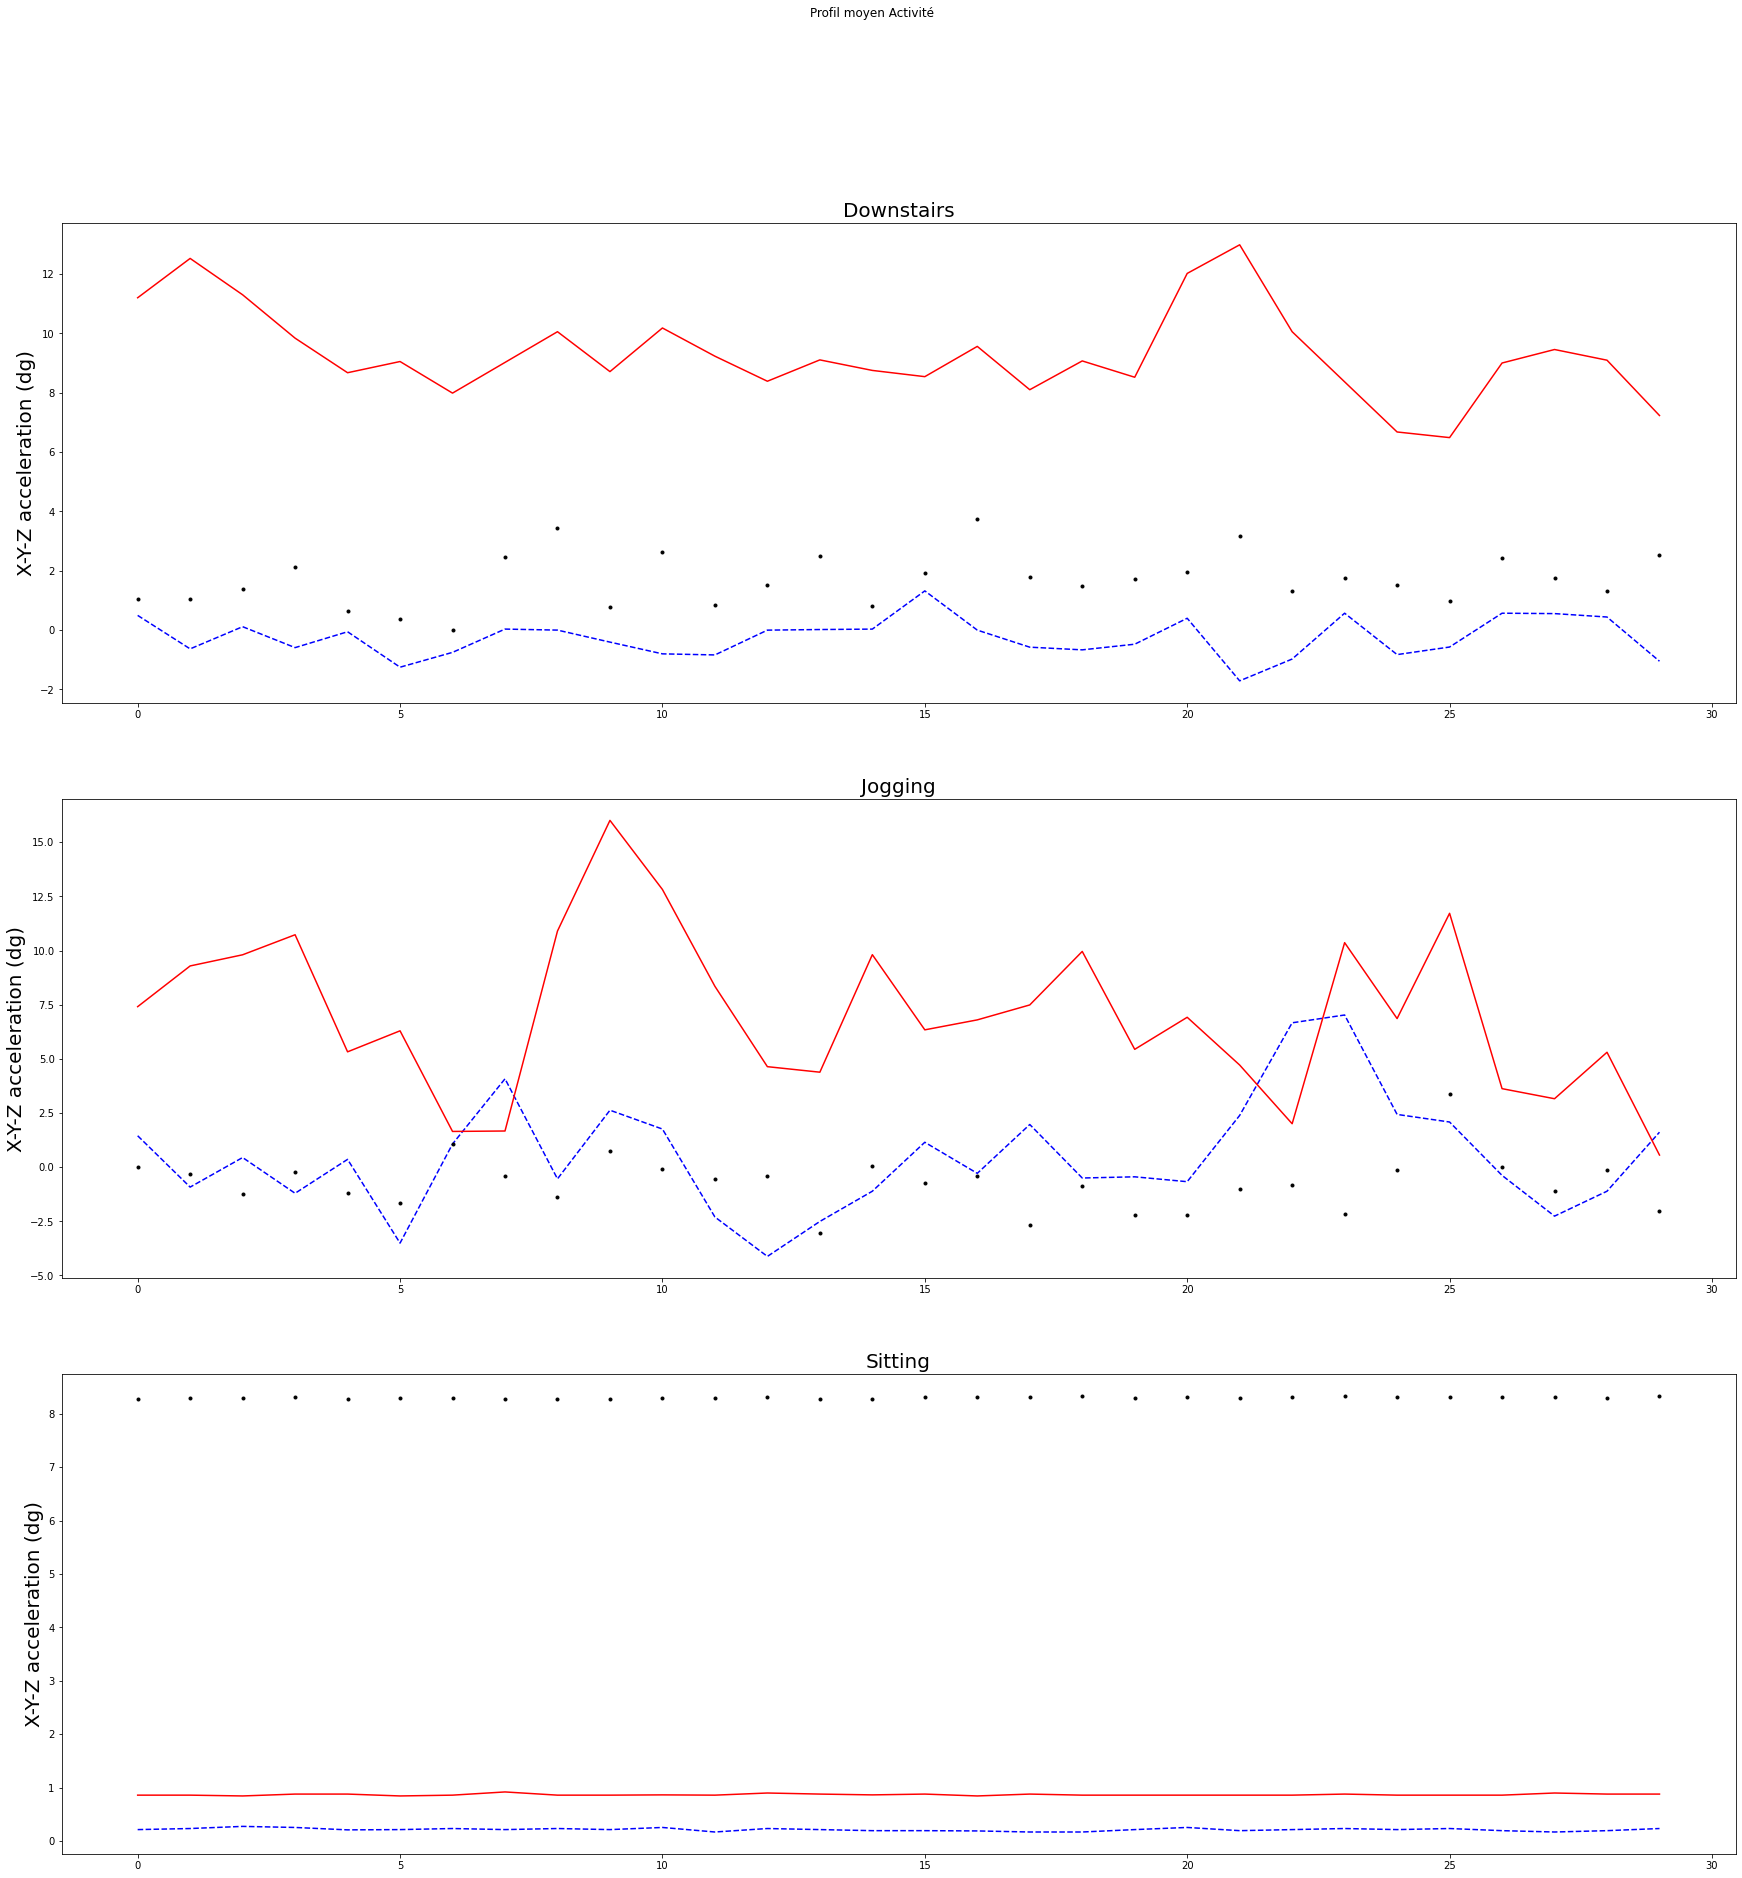

In [123]:
# Chargement
data = pd.read_csv(DATA_PATH, header=None, names=COLUMN_NAMES)
data['z-axis'].replace({';': ''}, regex=True, inplace=True)
data = data.dropna()

# DATA PREPROCESSING
data_convoluted = []
labels = []



# Prendre des segments temporels de taille SEGMENT_TIME_SIZE 
# tous les TIME_STEP pour une même activité
for j in range(0,N_CLASSES):
    DataBest=data[data['activity'] == LABELS[j]]
    for i in range(0, len(DataBest) - SEGMENT_TIME_SIZE, TIME_STEP):
        x = DataBest['x-axis'].values[i: i + SEGMENT_TIME_SIZE]
        y = DataBest['y-axis'].values[i: i + SEGMENT_TIME_SIZE]
        z = DataBest['z-axis'].values[i: i + SEGMENT_TIME_SIZE]
        data_convoluted.append([x, y, z])
    # Label de l'activité associé à chaque segment
        label = j
        labels.append(label)


# Conversion numpy
data_convoluted = np.asarray(data_convoluted, dtype=np.float32).transpose(0, 2, 1)
labels = np.asarray(labels, dtype=np.int)
print("Convoluted data shape: ", data_convoluted.shape)
print("Labels shape:", labels.shape)



fig, axs = plt.subplots(N_CLASSES,figsize=(30,30))
fig.suptitle('Profil moyen Activité')

profil_moyen=np.zeros((N_CLASSES,SEGMENT_TIME_SIZE,N_FEATURES))
List_Data_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Data_Test=np.zeros((N_CLASSES*TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
Data_App=np.zeros((TAILLE_APP*N_CLASSES,SEGMENT_TIME_SIZE*N_FEATURES))
Label_Test=np.zeros(N_CLASSES*TAILLE_TEST)
Label_App=np.zeros(N_CLASSES*TAILLE_APP)

for i in range(N_CLASSES):
    # Selection des données correspondant à la classe i
    print('Classe N°',i)
    res=np.where(labels==i)
    res=np.array(res)
    res=np.ravel(res)
    taille=res.shape[0]
    
    # Création de la base de Test par tirage aléatoire sur les 
    # profils temporels
    tirage=np.random.randint(0,taille,TAILLE_TEST)
    List_Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=res[tirage[0:TAILLE_TEST]]
    Label_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST]=i
    tir_dataTest=data_convoluted[res[tirage[0:TAILLE_TEST]],:,:]
    Data_Test[i*TAILLE_TEST:(i+1)*TAILLE_TEST,:]=np.reshape(tir_dataTest,(TAILLE_TEST,SEGMENT_TIME_SIZE*N_FEATURES))
    
    
    # Création de la base d'Apprentissage par tirage aléatoire sur les 
    # profils temporels
    tirage1=np.random.randint(0,taille,TAILLE_APP)
    tir_dataApp=data_convoluted[res[tirage1[0:TAILLE_APP]],:,:]
    Data_App[i*TAILLE_APP:(i+1)*TAILLE_APP,:]=np.reshape(tir_dataApp,(TAILLE_APP,SEGMENT_TIME_SIZE*N_FEATURES))
    Label_App[i*TAILLE_APP:(i+1)*TAILLE_APP]=i
    
    # Affichage du profil temporel median de la classe 
    class1=np.median(tir_dataApp,axis=0)
    profil_moyen[i,:,:]=class1
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,0],'b--')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,1],'r-')
    axs[i].plot(range(SEGMENT_TIME_SIZE),class1[:,2],'k.')
    axs[i].set_ylabel('X-Y-Z acceleration (dg)',fontsize=20)
    axs[i].set_title(LABELS[i], fontsize=20)



# Partie I : Implémentation de l'algorithme de programmation dynamique 

1. Ecrivez une fonction en python DTW qui implémente le calcul et l'affichage de la matrice des coûts définie en TD. 

2. Afin d'adapter facilement le calcul des coûts suivant la nature des données (et donc des distances utilisées), écrivez une fonction pour chaque distance (euclidienne, lettres, sons) qui apparaîtra en paramètre de la fonction DTW.

In [124]:
# Fonction DTW à implémenter

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


In [125]:
from math import *
import numpy as np
import sys

In [126]:
w0=5
w1=3
w3=10



In [127]:


def DTW(A, B, window = sys.maxsize, d = lambda x,y: np.linalg.norm((x-y))):
    # create the cost matrix
    A= np.array(A)
    B= np.array(B)
    M= len(A)
    N= len(B)
    cost = np.ones((M, N))

    # initialize the first row and column
    cost[0, 0] = d(A[0], B[0])
    for i in range(1, M):
        cost[i, 0] = cost[i-1, 0] + d(A[i], B[0])

    for j in range(1, N):
        cost[0, j] = cost[0, j-1] + d(A[0], B[j])
    # fill in the rest of the matrix
    for i in range(1, M):
        for j in range(max(1, i - window), min(N, i + window)):
            choices = w2*cost[i - 1, j - 1], w1*cost[i, j-1], w3*cost[i-1, j]
            cost[i, j] = min(choices) + d(A[i], B[j])

    # find the optimal path
    n, m = N - 1, M - 1
    path = []

    while (m, n) != (0, 0):
        path.append((m, n))
        m, n = min((m - 1, n), (m, n - 1), (m - 1, n - 1), key = lambda x: cost[x[0], x[1]])
    
    path.append((0,0))
    return cost[-1, -1]/(N+M), path

### Application aux exercices 

 Testez vos programmes sur les exercices vus en TD. 



In [128]:
# Test sur exos de TD

Score DTW entre les 2 séquences :  3.6


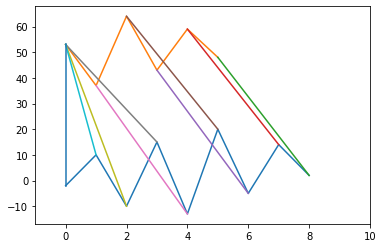

In [129]:

# Exercice 1
A=np.array([-2,10,-10,15,-13,20,-5,14,2])
B=np.array([3,-13,14,-7,9,-2])

cost, path = DTW(A, B, window = max(len(A),len(B)))
print('Score DTW entre les 2 séquences : ', cost)
    
offset = 50
plt.xlim([-1, max(len(A), len(B)) + 1])
plt.plot(A)
plt.plot(B+offset)
for (x1, x2) in path:
    plt.plot([x1, x2], [A[x1], B[x2] + offset])
plt.show()

# Partie II : Système de reconnaissance d'activité physique avec la DTW



Pour chaque profil temporel test,
- Calculer pour chaque classe, le score de la DTW entre le profil temporel test et les profils temporels de la classe 
- Déterminer la classe d'appartenance par minimum du score sur toutes les classes



In [130]:
# Système de reconnaissance à partir de la DTW
print(TAILLE_TEST)
PartitionDTW=np.zeros((TAILLE_TEST*N_CLASSES,2))

for num in range(TAILLE_TEST*N_CLASSES):
    #print('Donnee N°',num)
    result=np.zeros(N_CLASSES)
    for i in range(N_CLASSES):
        val=int(List_Data_Test[num])
        # A généraliser pour d'autres profils d'activité de la base 
        # d'apprentissage (pas seulement le profil moyen)
        cost,path =DTW(data_convoluted[val,:,:],profil_moyen[i,:,:])
        result[i]=cost
        index=np.argmin(result)
        PartitionDTW[num,0]=index
        PartitionDTW[num,1]=Label_Test[num]

50


## Evaluation des résultats de la DTW

A partir de la partition de l'ensemble test obtenue après la DTW, calculer la matrice de confusion qui recense le nombre de données bien classés et mal classés.

Matrice de confusion par DTW
Accuracy sur base de test : 0.7


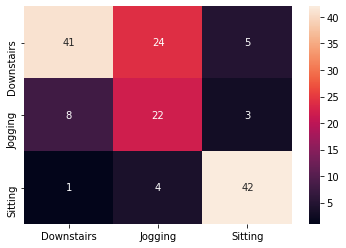

In [131]:
# Evaluation des résultats par matrices de confusion 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

print('Matrice de confusion par DTW')
cm=confusion_matrix(PartitionDTW[:,0],PartitionDTW[:,1])
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[:N_CLASSES]),yticklabels=np.unique(LABELS[:N_CLASSES]),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(PartitionDTW[:,0],PartitionDTW[:,1]))

# Partie III : Comparaison de la programmation dynamique avec une méthode de classification après prétraitement des données

Dans cette partie, nous allons comparer les résultats de la DTW avec ceux d'une méthode de classification de données : les k-plus proches voisins.

Nous utiliserons les fonctions permettant de calculer l'ACP et les kppv via la librairie python *scikit-learn*.





In [132]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D

### Prétraitement par ACP

Pour tester une autre méthode de classification, 

1. A partir des données Data_App de la base d'apprentissage et en utilisant la fonction *PCA* de la librairie *scikit-learn*, calculez les 3 axes principaux de l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$.Ces vecteurs propres constitueront la nouvelle base de données.

2. Projetez les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque
vecteur par la base $P = [X_1X_2X_3]$.

*Remarque :* vous pouvez aussi implémenter l'ACP en
extrayant les 3 vecteurs propres, notés $X_1$, $X_2$, $X_3$, associés aux 3 plus grandes valeurs propres de la matrice de
variance-covariance $\Sigma_{App}$ (par les fonctions *np.cov* et *np.linalg.eig*). Ces vecteurs propres constitueront le nouveau repère P.  Projetez ensuite les données de la base d'apprentissage et de test dans cette nouvelle base en multipliant chaque vecteur par la base $P = [X_1X_2X_3]$.




Dimension Base Apprentissage (30, 90)
(90, 30)
Dimension S (90, 90)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


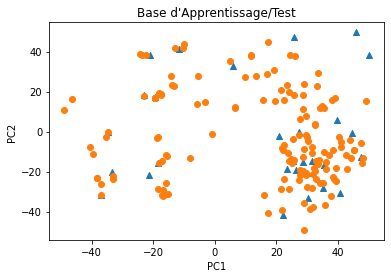

Contraste : (0.46967118111245+0j)


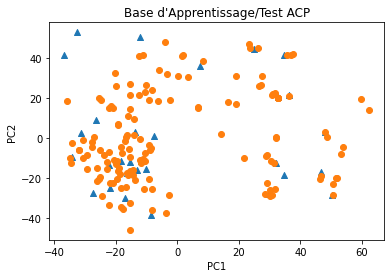

0.4696711811124495


In [133]:
from sklearn.decomposition import PCA

n_components=2
print('Dimension Base Apprentissage',Data_App.shape)
#print(Data_Test.shape)

# En implémentant l'ACP 
T=np.transpose(Data_App)
print(T.shape)
cov_mat=np.cov(np.transpose(Data_App))
print('Dimension S',cov_mat.shape)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

principalAxes=np.zeros((Data_App.shape[1],n_components))
for i in range(n_components):
    principalAxes[:,i]=eig_vecs[:,i]

principalComponentsApp = Data_App.dot(principalAxes)
principalComponentsTest = Data_Test.dot(principalAxes)

# affichage des points

plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
plt.title("Base d'Apprentissage/Test")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()


# Pourcentage d'information conservée
Contraste=sum(eig_vals[range(n_components)])/sum(eig_vals)
print("Contraste :", Contraste)

# En utilisant sklearn    
pca = PCA(n_components)
principalComponentsApp = pca.fit_transform(Data_App)
principalComponentsTest= pca.transform(Data_Test)

# affichage des points
plt.scatter(principalComponentsApp[:, 0], principalComponentsApp[:, 1],marker='^')
plt.scatter(principalComponentsTest[:, 0], principalComponentsTest[:, 1],marker='o')
plt.title("Base d'Apprentissage/Test ACP")
plt.xlabel("PC1")
plt.ylabel("PC2");
plt.show()


# Conservation de l'information : Variance 
print(sum(pca.explained_variance_ratio_))







### Classification par k plus proches voisins

En intelligence artificielle, la méthode des k plus proches voisins (k-ppv) est une méthode d'apprentissage
supervisé. Dans ce cadre, on dispose d'une base de données d'apprentissage constituée de couples  "donnée-label". Pour estimer la sortie associée à une nouvelle entrée x, la méthode des k plus proches voisins consiste à prendre
en compte (de façon identique) les k échantillons d'apprentissage dont l'entrée est la plus proche de la nouvelle
entrée x, selon une distance à définir. L'algorithme 1 associé et un exemple (figure 1) sont données par la suite.

<img src="files/AlgoKppv.png" width="900" height="800"  >

<img src="files/kppv.png" width="300" height="300"  >

**Exemple de classification par k-ppv.** L'échantillon de test (cercle vert) doit être classé soit dans la première
classe des carrés bleus, soit dans la deuxième classe des triangles rouges. 
Si k = 3 (cercle plein), il est assigné à la deuxième classe parce qu'il y a 2 triangles et seulement 1 carré à l'intérieur du cercle intérieur. 
Si k = 5 (cercle en pointillés), il est assigné à la première classe (3 carrés contre 2 triangles à l'intérieur du cercle extérieur)


1. En utilisant la fonction *KNeighborsClassifier* de la librairie *sklearn.neighbors*, réalisez une classification par k-ppv sur la base d'apprentissage et la base de test que vous avez prédéfinies (prendre $k=1$).

2. Evaluez la méthode des k-ppv par le calcul de la matrice de confusion et du taux de reconnaissance.

3. Modifiez la valeur de $k$ pour les k-ppv. Améliorez-vous les scores de reconnaissance ?

4. Comparez vos résultats avec ceux de la DTW.




Matrice de confusion avec ACP+kNN
Accuracy sur base de test : 0.6666666666666666


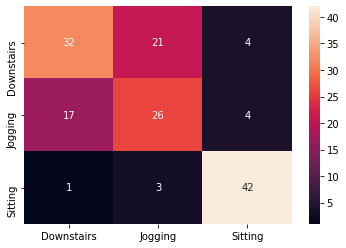

In [134]:
error=[]


knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(principalComponentsApp, Label_App)
pred_i = knn.predict(principalComponentsTest)

# Evaluation des résultats par matrices de confusion 
print('Matrice de confusion avec ACP+kNN')
cm=confusion_matrix(pred_i,Label_Test)
sns.heatmap(data=cm,fmt='.0f',xticklabels=np.unique(LABELS[0:N_CLASSES]),yticklabels=np.unique(LABELS[0:N_CLASSES]),annot=True)

# score de performance
print('Accuracy sur base de test :',accuracy_score(pred_i,Label_Test))


# Partie IV : Votre étude

Réalisez votre propre étude en :
- en Augmentant les bases de test et/ou d'apprentissage et/ou la durée des segments 
- en proposant des variantes (changement de norme pour la DTW, pondération différente pour les wi, contrainte locale, testez avec davantage de vecteurs propres pour l'ACP (utiliser le contraste)...)
- en rajoutant davantage de classes (jusqu'à 3 supplémentaires : 4-Debout, 5-Monter ou 6-Marcher ) 
le tout en testant les deux approches et en interprétant les résultats, à synthétiser sur un rapport. 
